In [1]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm
tqdm.pandas()

In [2]:
# 試験ID生成
trial_prefix = 'nb010'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb010
nb010_20210527_233150


In [3]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [5]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [6]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [7]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [8]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [10]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## テキスト特徴_fasttest

In [15]:
import fasttext

ft_model = fasttext.load_model('../97_pre_trained/cc.en.300.bin')

In [16]:
ft_model

In [21]:
text_normalization(train_base['excerpt'])[0]

'young people returned ballroom presented decidedly changed appearance instead interior scene winter landscapethe floor covered snowwhite canvas laid smoothly rumpled bumps hillocks like real snow field numerous palms evergreens decorated room powdered flour strewn tufts cotton like snow also diamond dust lightly sprinkled glittering crystal icicles hung branchesat end room wall hung beautiful bearskin rugthese rugs prizes one girls one boys gamethe girls gathered one end room boys one end called north pole south pole player given small flag plant reaching polethis would easy matter traveller obliged wear snowshoes'

In [22]:
features = ft_model.get_sentence_vector(text_normalization(train_base['excerpt'])[0])


In [25]:
tg_excerpt = text_normalization(train_base['excerpt'])

In [28]:
feat = tg_excerpt.map(lambda x: ft_model.get_sentence_vector(x))
pd.DataFrame(np.stack(feat.values))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.001151,0.012352,-0.000500,0.077889,-0.009556,-0.009894,0.039337,0.004011,0.004635,0.010583,...,0.006159,-0.012381,-0.055438,0.014458,0.002121,-0.011442,-0.006072,0.073328,0.011750,-0.015344
1,0.007280,0.015286,0.011801,0.083053,-0.024567,-0.018924,0.010829,-0.016149,0.003360,0.003613,...,0.031228,0.011953,-0.079501,0.012580,0.010354,-0.013913,-0.007665,0.061753,0.006969,0.001245
2,0.004572,0.020914,0.001168,0.071801,-0.028248,-0.011573,0.006764,-0.014381,0.005510,0.000220,...,0.015746,-0.005854,-0.092407,0.013528,0.009924,-0.000415,-0.010161,0.066459,0.001143,-0.010281
3,-0.012602,0.000471,-0.004536,0.068844,0.002874,0.001680,0.042202,-0.009786,0.003903,0.031925,...,-0.001111,-0.011578,-0.062161,0.007171,-0.007188,-0.014722,-0.027742,0.073340,0.020443,-0.000597
4,0.018223,-0.040480,-0.011506,0.092131,-0.014986,0.013169,0.066798,-0.006899,-0.006002,0.004477,...,0.033408,-0.022799,-0.078124,0.040264,0.010673,-0.001343,-0.027711,0.100369,-0.004425,-0.012164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,-0.002085,0.008509,-0.026447,0.057620,-0.003777,-0.033524,0.031666,-0.003441,0.000364,-0.025391,...,-0.005844,-0.007216,-0.071180,-0.001923,0.011533,0.035422,-0.003129,0.060778,0.014434,0.007777
2830,-0.024310,0.002957,0.029773,0.083822,-0.031194,-0.032541,0.046322,-0.017162,0.010029,-0.005655,...,0.024921,-0.005647,-0.056983,-0.005828,0.013207,0.019101,-0.004090,0.063547,-0.001697,-0.012692
2831,-0.014418,0.019972,0.002691,0.090894,-0.018539,-0.008736,0.066472,-0.001805,0.021921,-0.015954,...,0.026327,-0.019904,-0.052911,-0.000444,-0.005618,0.027354,-0.010020,0.063171,0.012132,-0.013649
2832,-0.019578,0.004832,0.016001,0.065343,-0.012579,-0.033379,0.037904,-0.010858,0.005050,-0.016452,...,0.019614,-0.003087,-0.045349,-0.003903,0.003056,0.005380,-0.012048,0.061633,0.001017,-0.007903


In [ ]:
df["title"].fillna("").str.replace("\n", "").map(
        lambda x: ft_model.get_sentence_vector(x)


In [35]:
type(ft_model)

fasttext.FastText._FastText

In [42]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1

class FasttextBlock(BaseBlock):
    """文書をfasttextのテキスト表現へ変換する block"""
    def __init__(self, column: str, ft_model:fasttext.FastText._FastText):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.ft_model = ft_model

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: ft_model.get_sentence_vector(x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'fasttext_{self.column}_')

In [43]:
fast = FasttextBlock('excerpt', ft_model)
fast.fit(train_base)

,fasttext_excerpt_0,fasttext_excerpt_1,fasttext_excerpt_2,fasttext_excerpt_3,fasttext_excerpt_4,fasttext_excerpt_5,fasttext_excerpt_6,fasttext_excerpt_7,fasttext_excerpt_8,fasttext_excerpt_9,...,fasttext_excerpt_290,fasttext_excerpt_291,fasttext_excerpt_292,fasttext_excerpt_293,fasttext_excerpt_294,fasttext_excerpt_295,fasttext_excerpt_296,fasttext_excerpt_297,fasttext_excerpt_298,fasttext_excerpt_299
0,-0.001151,0.012352,-0.000500,0.077889,-0.009556,-0.009894,0.039337,0.004011,0.004635,0.010583,...,0.006159,-0.012381,-0.055438,0.014458,0.002121,-0.011442,-0.006072,0.073328,0.011750,-0.015344
1,0.007280,0.015286,0.011801,0.083053,-0.024567,-0.018924,0.010829,-0.016149,0.003360,0.003613,...,0.031228,0.011953,-0.079501,0.012580,0.010354,-0.013913,-0.007665,0.061753,0.006969,0.001245
2,0.004572,0.020914,0.001168,0.071801,-0.028248,-0.011573,0.006764,-0.014381,0.005510,0.000220,...,0.015746,-0.005854,-0.092407,0.013528,0.009924,-0.000415,-0.010161,0.066459,0.001143,-0.010281
3,-0.012602,0.000471,-0.004536,0.068844,0.002874,0.001680,0.042202,-0.009786,0.003903,0.031925,...,-0.001111,-0.011578,-0.062161,0.007171,-0.007188,-0.014722,-0.027742,0.073340,0.020443,-0.000597
4,0.018223,-0.040480,-0.011506,0.092131,-0.014986,0.013169,0.066798,-0.006899,-0.006002,0.004477,...,0.033408,-0.022799,-0.078124,0.040264,0.010673,-0.001343,-0.027711,0.100369,-0.004425,-0.012164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,-0.002085,0.008509,-0.026447,0.057620,-0.003777,-0.033524,0.031666,-0.003441,0.000364,-0.025391,...,-0.005844,-0.007216,-0.071180,-0.001923,0.011533,0.035422,-0.003129,0.060778,0.014434,0.007777
2830,-0.024310,0.002957,0.029773,0.083822,-0.031194,-0.032541,0.046322,-0.017162,0.010029,-0.005655,...,0.024921,-0.005647,-0.056983,-0.005828,0.013207,0.019101,-0.004090,0.063547,-0.001697,-0.012692
2831,-0.014418,0.019972,0.002691,0.090894,-0.018539,-0.008736,0.066472,-0.001805,0.021921,-0.015954,...,0.026327,-0.019904,-0.052911,-0.000444,-0.005618,0.027354,-0.010020,0.063171,0.012132,-0.013649
2832,-0.019578,0.004832,0.016001,0.065343,-0.012579,-0.033379,0.037904,-0.010858,0.005050,-0.016452,...,0.019614,-0.003087,-0.045349,-0.003903,0.003056,0.005380,-0.012048,0.061633,0.001017,-0.007903


In [44]:
assert len(train_base) == len(FasttextBlock('excerpt', ft_model).fit(train_base))

## テキスト特徴_統計量

In [45]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None, n_components=50):
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)
        return self.transform(input_df)

    def transform(self, input_df):
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = self.counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1)
        return out_df.add_suffix(f'_{self.column}')

## テキスト特徴_TF-IDF

In [46]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_W2V(データセットから学習)

In [47]:
# https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

class W2VTrainBlock(BaseBlock):
    """Word2Vecを学習し、文書のベクトル表現を得るブロック。
       学習済みモデルを使うパターンは、別に作成するものとする。"""
    def __init__(self, 
                 column: str, 
                 model_size=50, 
                 min_count=1, 
                 window=5,
                 n_iter=100
                 ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model_size=model_size
        self.min_count=min_count
        self.window=window
        self.n_iter=n_iter

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """Word2Vecを学習するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])
        self.w2v_model = word2vec.Word2Vec(word_lists.values.tolist(),
                                      vector_size=self.model_size,
                                      min_count=self.min_count,
                                      window=self.window,
                                      seed=SEED,
                                      workers=1,
                                      hashfxn=hashfxn,
                                      epochs=self.n_iter)

        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = word_lists.progress_apply(
            lambda x: np.mean([self.w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{self.column}_w2v_w{self.window}_{i}"
                                                   for i in range(self.model_size)])
        
        return sentence_vector_df


# make_feat

In [48]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')

In [49]:
# block初期化
text_desc = TextDescriptionBlock('excerpt')

tfidf_uni = TfidfBlock('excerpt', ngram_range=(1,1))
tfidf_bi = TfidfBlock('excerpt', ngram_range=(2,2))
tfidf_uni_bi = TfidfBlock('excerpt', ngram_range=(1,2))

w2v_w3 = W2VTrainBlock('excerpt', window=3)
w2v_w10 = W2VTrainBlock('excerpt', window=10)
w2v_w100 = W2VTrainBlock('excerpt', window=100)

fast = FasttextBlock('excerpt', ft_model)

In [50]:
# fit & trainの特徴作成
# 単体で完結するもの
train_feat = pd.concat([train_feat, text_desc.fit(train_base)], axis='columns')
train_feat = pd.concat([train_feat, fast.fit(train_base)], axis='columns')

# 対象dfとは別に、特徴作成用dfを指定するもの
train_feat = pd.concat([train_feat, tfidf_uni.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_bi.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_uni_bi.fit(train_base, whole_df)], axis='columns')

train_feat = pd.concat([train_feat, w2v_w3.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w10.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w100.fit(train_base, whole_df)], axis='columns')

100%|██████████| 2834/2834 [00:00<00:00, 5381.56it/s]


In [51]:
# testの特徴作成
# 単体で完結するもの
test_feat = pd.concat([test_feat, text_desc.fit(test_base)], axis='columns')
test_feat = pd.concat([test_feat, fast.fit(test_base)], axis='columns')

# 対象dfとは別に、特徴作成用dfを指定するもの
test_feat = pd.concat([test_feat, tfidf_uni.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_bi.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_uni_bi.transform(test_base)], axis='columns')

test_feat = pd.concat([test_feat, w2v_w3.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w10.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w100.transform(test_base)], axis='columns')

100%|██████████| 7/7 [00:00<00:00, 2470.98it/s]


In [52]:
print(train_feat.shape)
train_feat.head()

(2834, 612)


,text_length_excerpt,word_count_excerpt,word_nunique_excerpt,word_appearance_mean_excerpt,word_appearance_max_excerpt,word_length_mean_excerpt,word_length_std_excerpt,word_length_min_excerpt,word_length_25%_excerpt,word_length_50%_excerpt,...,excerpt_w2v_w100_40,excerpt_w2v_w100_41,excerpt_w2v_w100_42,excerpt_w2v_w100_43,excerpt_w2v_w100_44,excerpt_w2v_w100_45,excerpt_w2v_w100_46,excerpt_w2v_w100_47,excerpt_w2v_w100_48,excerpt_w2v_w100_49
0,992,89,76,1.171053,4,6.381579,2.039393,3.0,5.0,6.0,...,-0.217041,-0.947086,-0.240424,-0.611567,0.519498,2.125340,-0.820808,-1.667538,-0.654386,-1.474729
1,937,85,75,1.133333,4,5.786667,2.225730,2.0,4.0,5.0,...,-0.795910,0.255854,-1.411194,0.588701,-1.221988,-1.019004,-0.103182,-1.526404,-1.114527,0.189374
2,908,83,74,1.121622,4,5.716216,2.205350,2.0,4.0,5.0,...,-1.815394,0.674283,0.139342,-0.419321,0.574165,-0.946741,1.381261,-0.147840,-1.629534,-0.666281
3,909,91,82,1.109756,2,5.548780,1.873483,3.0,4.0,5.0,...,0.435203,-1.886962,0.574152,-1.713401,-1.171950,1.026424,-1.042995,-0.552586,-0.674904,-0.339205
4,723,70,23,3.043478,12,4.956522,1.918291,3.0,4.0,5.0,...,-2.343257,-2.362386,-1.318688,-0.575826,-1.870237,-1.380572,0.223847,-2.942811,2.636841,-0.459555


In [53]:
print(test_feat.shape)
test_feat.head()

(7, 612)


,text_length_excerpt,word_count_excerpt,word_nunique_excerpt,word_appearance_mean_excerpt,word_appearance_max_excerpt,word_length_mean_excerpt,word_length_std_excerpt,word_length_min_excerpt,word_length_25%_excerpt,word_length_50%_excerpt,...,excerpt_w2v_w100_40,excerpt_w2v_w100_41,excerpt_w2v_w100_42,excerpt_w2v_w100_43,excerpt_w2v_w100_44,excerpt_w2v_w100_45,excerpt_w2v_w100_46,excerpt_w2v_w100_47,excerpt_w2v_w100_48,excerpt_w2v_w100_49
0,772,72,65,1.107692,3,5.892308,1.668861,2.0,5.0,6.0,...,-0.182396,1.304855,1.133889,-0.532202,1.118977,-0.258137,0.267776,-0.037274,-1.066863,-2.415086
1,967,94,72,1.305556,4,5.347222,1.785384,2.0,4.0,5.0,...,-0.495243,-0.451200,-1.482514,-0.842126,-0.880548,-0.030492,0.162893,-0.895386,-1.217350,2.077919
2,948,86,79,1.088608,2,5.721519,2.159871,2.0,4.0,6.0,...,-1.926998,0.119433,-0.575311,-0.652626,-1.888911,0.342359,0.384725,-0.363403,-0.598372,-1.019676
3,1144,112,73,1.534247,11,7.164384,2.309483,3.0,6.0,7.0,...,-1.867393,-0.051688,-0.212039,-1.750688,-0.803866,-1.976228,-0.568357,2.862783,-0.751278,-0.260300
4,1094,103,88,1.170455,7,6.931818,2.372231,2.0,5.0,7.0,...,1.394626,0.257942,-0.942193,2.981604,-0.807661,-0.872389,1.659845,0.793504,1.001369,1.062877


In [54]:
print(train_feat.shape)
print(test_feat.shape)

(2834, 612)
(7, 612)


# train & predict

In [55]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [56]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [57]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [58]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [59]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154228
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 612
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.269556	valid's rmse: 0.672544
[100]	training's rmse: 0.11534	valid's rmse: 0.668847
[150]	training's rmse: 0.0521721	valid's rmse: 0.666907
Early stopping, best iteration is:
[142]	training's rmse: 0.0591334	valid's rmse: 0.66667

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154229
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 612
[LightGBM] [Info] Start tra

In [60]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [61]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-1.265441
1,f0953f0a5,-0.550550
2,0df072751,-0.786753
3,04caf4e0c,-2.086556
4,0e63f8bea,-2.019777


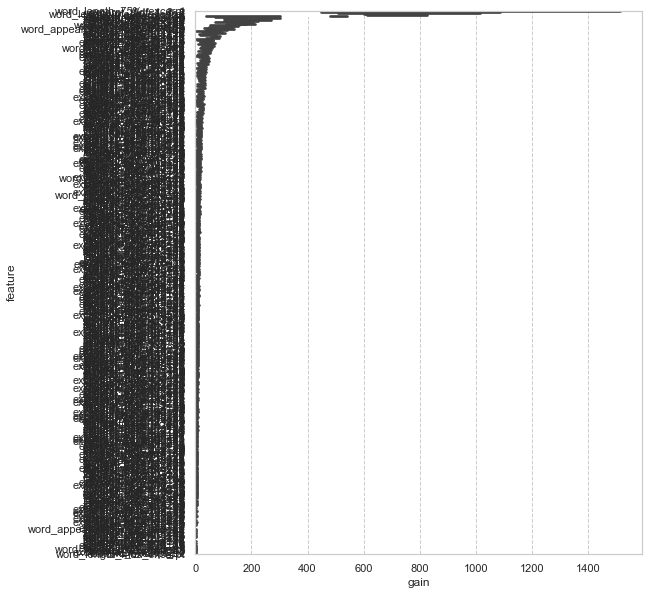

In [62]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

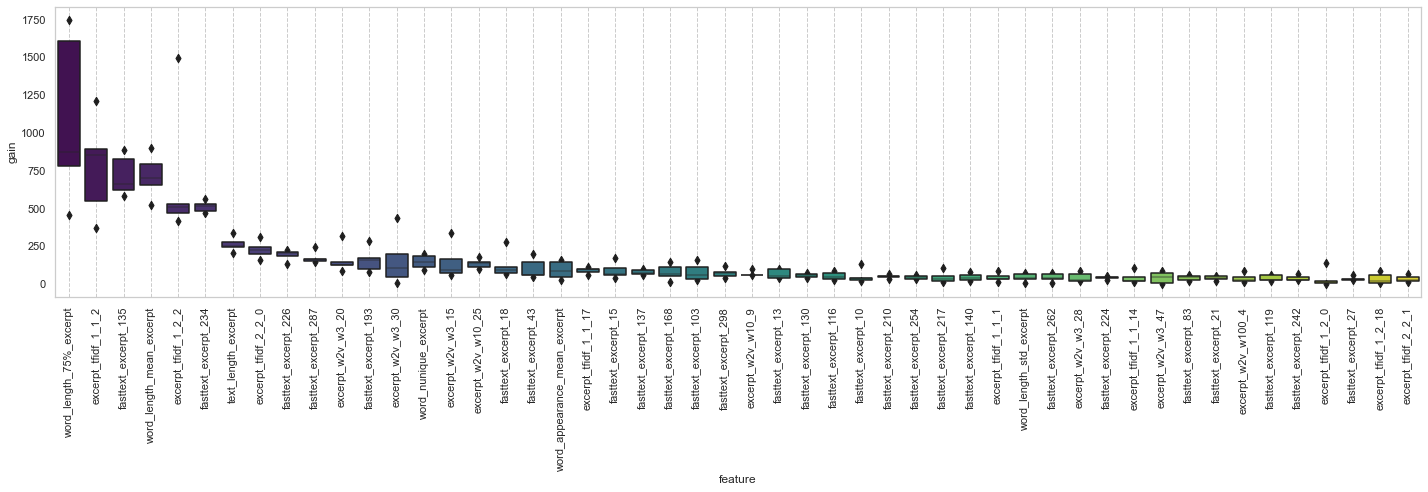

In [63]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [64]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

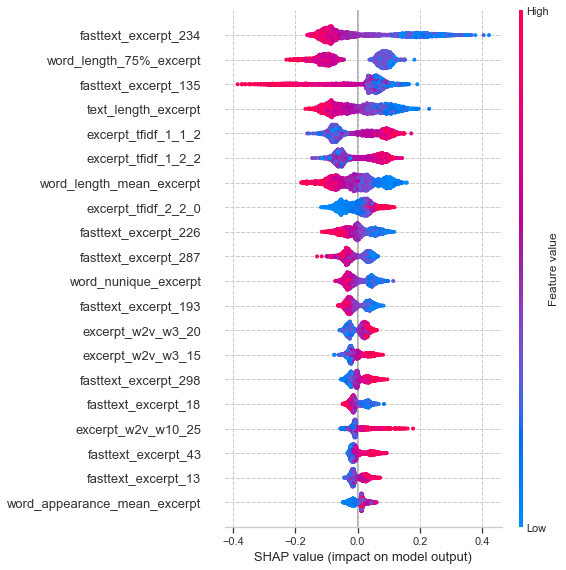

In [65]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

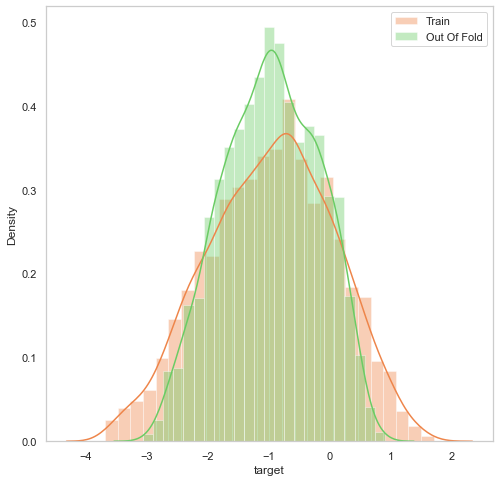

In [66]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))